*Contributed by: Jia Wen*

# Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load datasets
train = pd.read_csv('../assets/train_cleaned.csv')
test = pd.read_csv('../assets/test_cleaned.csv')
weather = pd.read_csv('../assets/weather_cleaned.csv')
spray = pd.read_csv('../assets/spray_cleaned.csv')

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
test.drop('Id', axis=1, inplace=True)
weather['Date'] = pd.to_datetime(weather['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Time'] = pd.to_datetime(spray['Time'])

print(train.shape)
print(test.shape)
print(weather.shape)
print(spray.shape)

(10506, 16)
(116293, 14)
(1472, 19)
(14251, 7)


In [3]:
train_weather = pd.merge(train, weather, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'], how='inner')
print(train_weather.shape)

train_weather.head(10).T

(10506, 30)


0  \
Date                                                  2007-05-29 00:00:00   
Address                 4100 North Oak Park Avenue, Chicago, IL 60634,...   
Species                                            CULEX PIPIENS/RESTUANS   
Block                                                                  41   
Street                                                     N OAK PARK AVE   
Trap                                                                 T002   
AddressNumberAndStreet                  4100  N OAK PARK AVE, Chicago, IL   
Latitude                                                         41.95469   
Longitude                                                      -87.800991   
AddressAccuracy                                                         9   
NumMosquitos                                                            1   
WnvPresent                                                              0   
Year                                                                 2007   
Month                                                                   5   
Week                                                                   22   
DayOfWeek                                                               1   
Tmax                                                                 88.0   
Tmin                                                                 62.5   
Tavg                                                                 75.5   
Depart                                                               11.5   
DewPoint                                                             58.5   
WetBulb                                                              65.5   
Heat                                                                  0.0   
Cool                                                                 10.5   
PrecipTotal                                                           0.0   
StnPressure                                                        29.415   
SeaLevel                                                             30.1   
ResultSpeed                                                           5.8   
ResultDir                                                            17.0   
AvgSpeed                                                             6.95   

                                                                        1  \
Date                                                  2007-05-29 00:00:00   
Address                 4100 North Oak Park Avenue, Chicago, IL 60634,...   
Species                                                    CULEX RESTUANS   
Block                                                                  41   
Street                                                     N OAK PARK AVE   
Trap                                                                 T002   
AddressNumberAndStreet                  4100  N OAK PARK AVE, Chicago, IL   
Latitude                                                         41.95469   
Longitude                                                      -87.800991   
AddressAccuracy                                                         9   
NumMosquitos                                                            1   
WnvPresent                                                              0   
Year                                                                 2007   
Month                                                                   5   
Week                                                                   22   
DayOfWeek                                                               1   
Tmax                                                                 88.0   
Tmin                                                                 62.5   
Tavg                                                                 75.5   
Depart                                                               11.5   
DewPoint                                                           

## Exploring Correlation

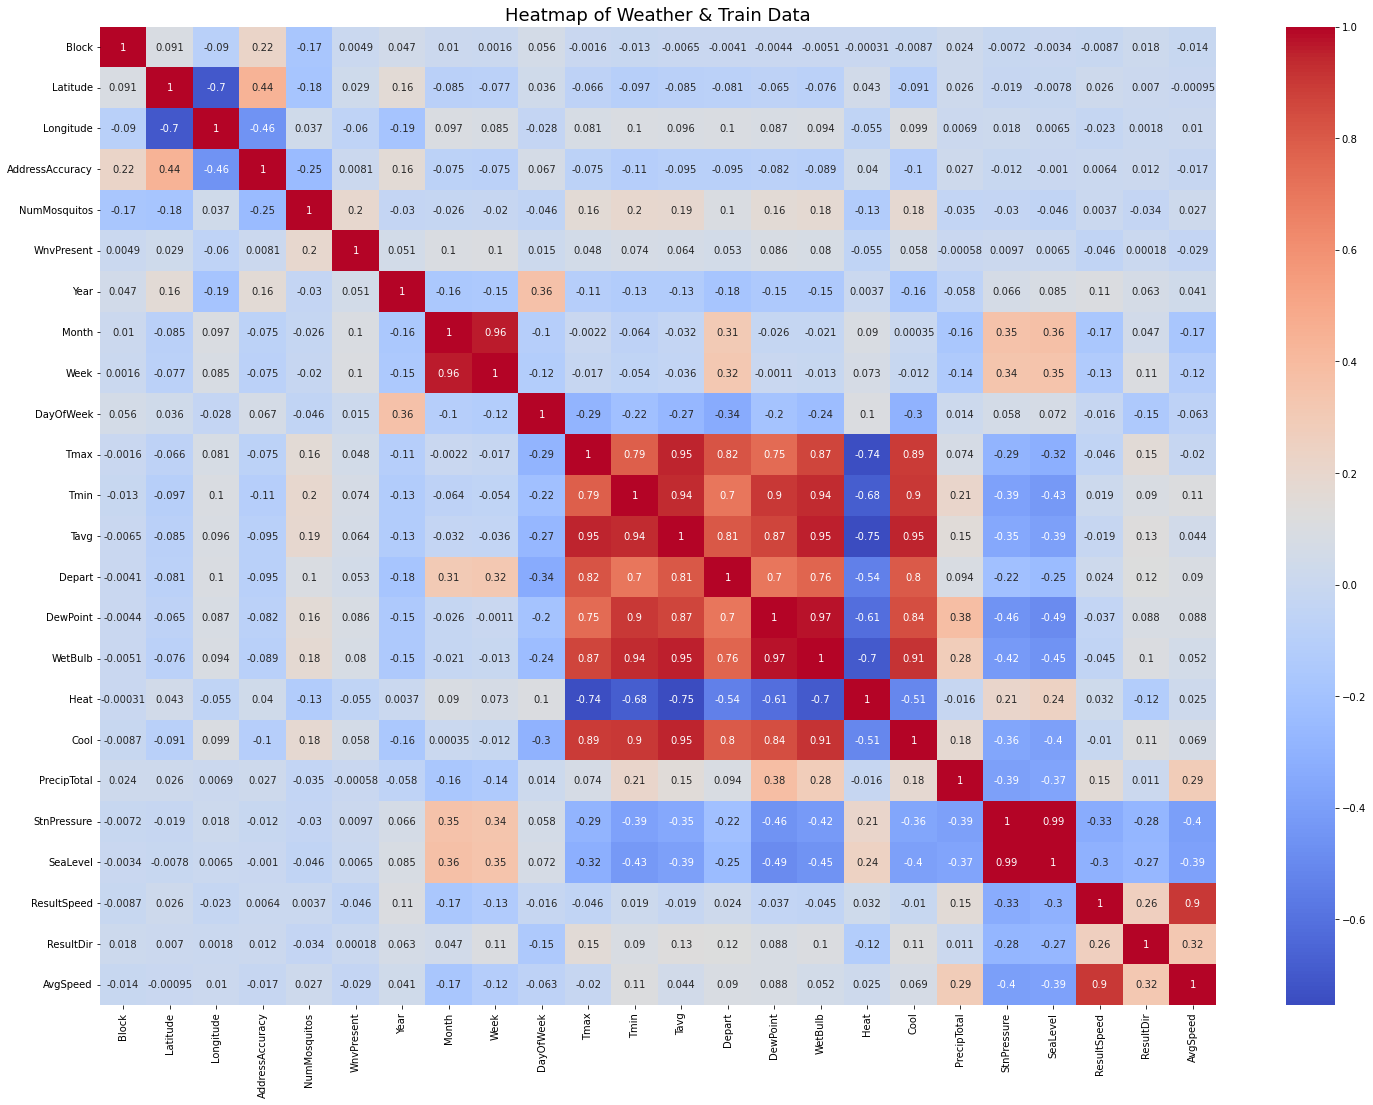

In [4]:
plt.figure(figsize=(25,18))
plt.title('Heatmap of Weather & Train Data',fontsize=18)
sns.heatmap(train_weather.corr(),annot=True, cmap="coolwarm");

From the heatmap above, we can see that 
- no feature is strong correlated to our target variable `WnvPresent`
- our data faces an issue with **multicollinearity**. We note that the following features are strongly correlated, as all these features are measurement for similar factors. e.g.:
    - `Tmin`, `Tmax`, `Tavg`, `DewPoint`, `WetBulb`, `Heat` and `Cool` (features measuring temperature)
    - `SeaLevel` and `StnPressure` (features measuring air pressure)
    - `ResultSpeed` and `AvgSpeed` (features measuring speed of wind)

However, these features are parameters that may affect our target variable `WnvPresent`, so we will not drop them.

## Occurrence of West Nile Virus

5.24% of the mosquitoes captured are WnvPresent


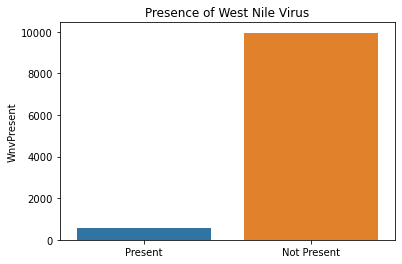

In [5]:
plt.title('Presence of West Nile Virus')
sns.barplot(x=["Present","Not Present"], y=train_weather['WnvPresent'].value_counts(ascending=True));

perc_nwv = round(train_weather['WnvPresent'].value_counts()[1]/train_weather['WnvPresent'].value_counts().sum(),4)*100
print(f'{perc_nwv}% of the mosquitoes captured are WnvPresent')

## Exploring Time Period

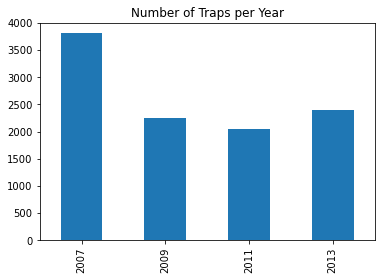

In [6]:
plt.title('Number of Traps per Year')
train['Year'].value_counts().sort_index(ascending=True).plot(kind = 'bar');

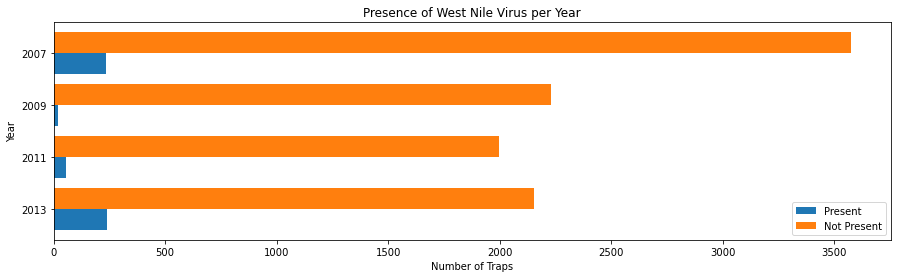

In [7]:
plt.figure(figsize=(15,4))

years = list(train_weather["Year"].unique())
years.reverse()
years_axis = np.arange(len(list(train_weather["Year"].unique())))

WnvPresent = []
for year in years:
    WnvPresent.append(train_weather[train_weather['WnvPresent']==1]["Year"].value_counts()[year])
    
WnvNotPresent = []
for year in years:
    WnvNotPresent.append(train_weather[train_weather['WnvPresent']==0]["Year"].value_counts()[year])

plt.barh(years_axis - 0.2, WnvPresent, 0.4, label = 'Present')
plt.barh(years_axis + 0.2, WnvNotPresent, 0.4, label = 'Not Present')

plt.yticks(years_axis, years)

plt.ylabel("Year")
plt.xlabel("Number of Traps")
plt.legend()
plt.title('Presence of West Nile Virus per Year')
plt.show()

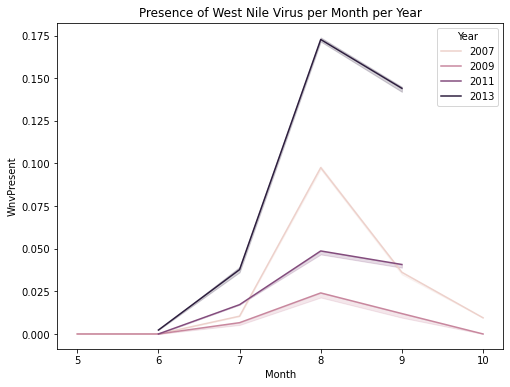

In [8]:
plt.figure(figsize=(8,6))
plt.title('Presence of West Nile Virus per Month per Year')

sns.lineplot(data = train_weather, 
             x='Month', 
             y='WnvPresent', 
             hue='Year',
             ci = 10);

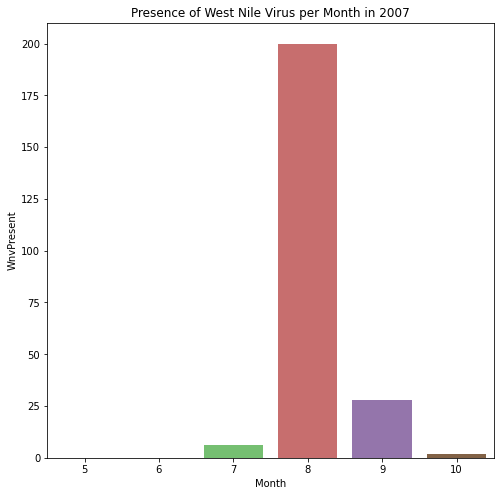

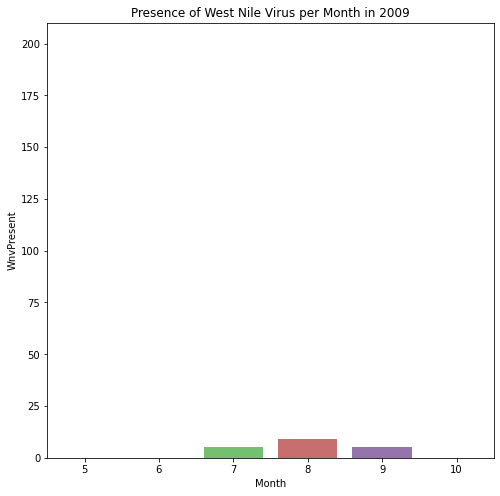

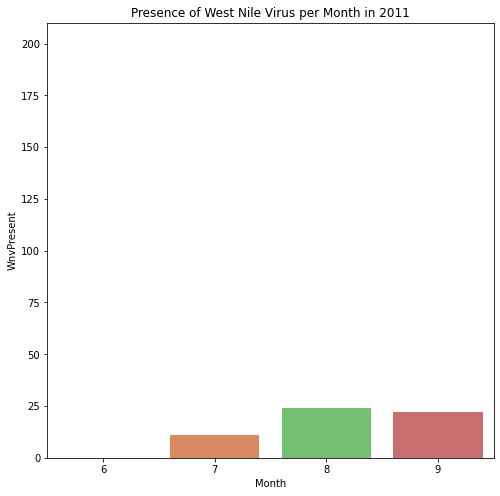

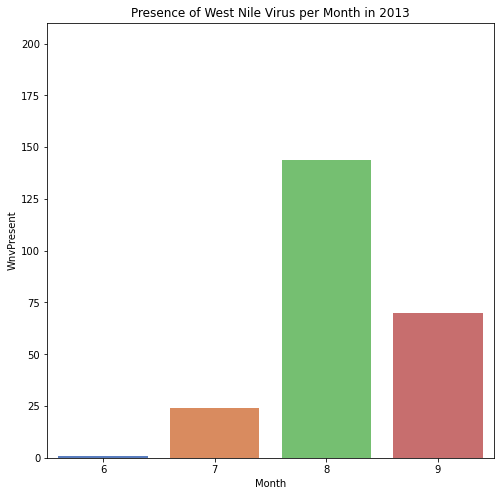

In [9]:
years = [2007, 2009, 2011, 2013]
max_val = max([train_weather[train_weather["Year"]==year].groupby(by='Month')["WnvPresent"].sum().max() for year in years])

for year in years:
    fig, ax = plt.subplots(1,1,figsize=(8,8))
    sns.barplot(data=train_weather[train_weather["Year"]==year].groupby(by='Month').sum().reset_index(), 
                x='Month', y='WnvPresent', ax=ax, palette="muted")
    plt.ylim([0, max_val+10])
    ax.set_title(f"Presence of West Nile Virus per Month in {year}");

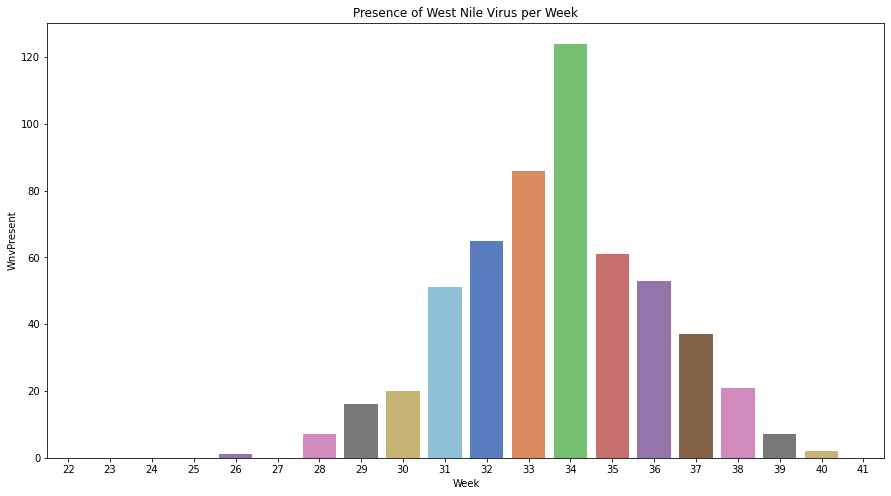

In [10]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.barplot(data=train_weather.groupby(by='Week').sum().reset_index(), 
            x="Week", y='WnvPresent', ax=ax, palette="muted")
ax.set_title("Presence of West Nile Virus per Week");

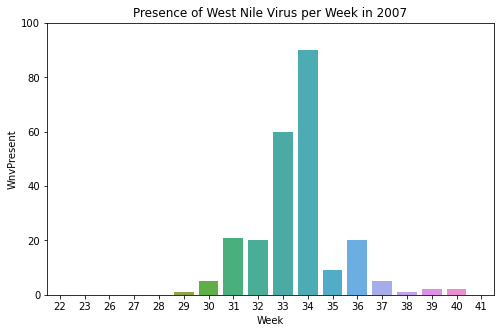

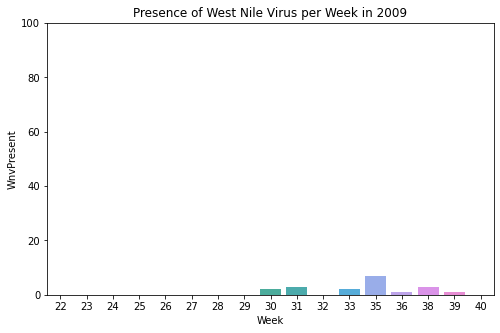

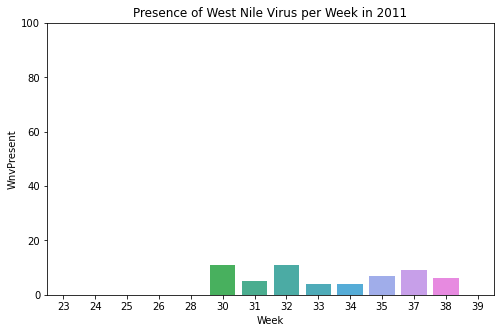

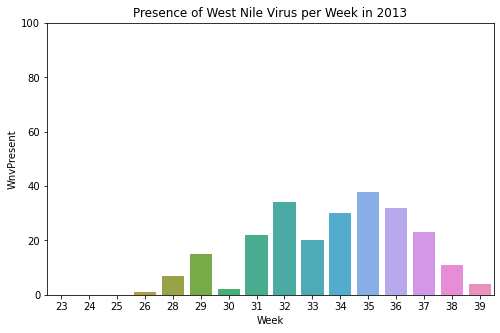

In [11]:
years = [2007, 2009, 2011, 2013]
max_val = max([train_weather[train_weather["Year"]==year].groupby(by='Week')["WnvPresent"].sum().max() for year in years])

for year in years:
    data = train_weather[train_weather["Year"]==year]
    fig, ax = plt.subplots(1,1,figsize=(8,5))
    sns.barplot(data=data.groupby(by='Week').sum().reset_index(), 
                x='Week', y='WnvPresent', ax=ax)
    plt.ylim([0, max_val+10])
    ax.set_title(f"Presence of West Nile Virus per Week in {year}");


## Exploring Features (Temperature)

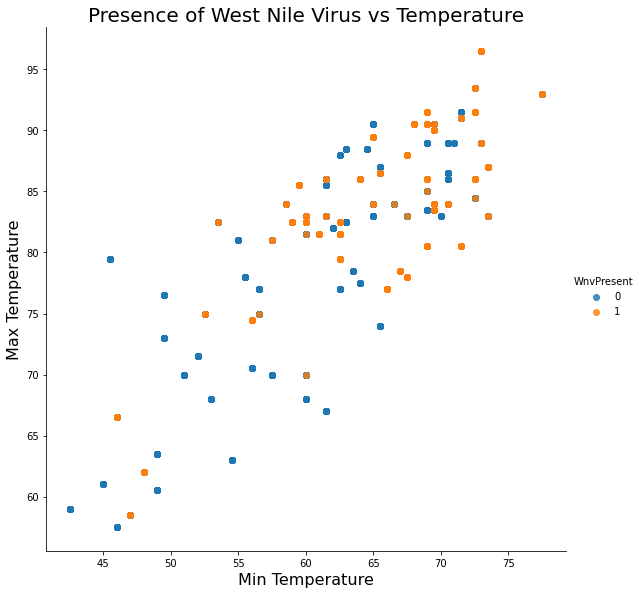

In [12]:
sns.lmplot( data=train_weather, 
           x='Tmin', 
           y='Tmax',  
           fit_reg=False, 
           hue='WnvPresent', 
           height=8)

plt.xlabel('Min Temperature', fontsize=16)
plt.ylabel('Max Temperature', fontsize=16)

plt.title('Presence of West Nile Virus vs Temperature', fontsize=20);

From the scatter plot, we can see that temperature is positively correlated to the occurrence of West Nile Virus.

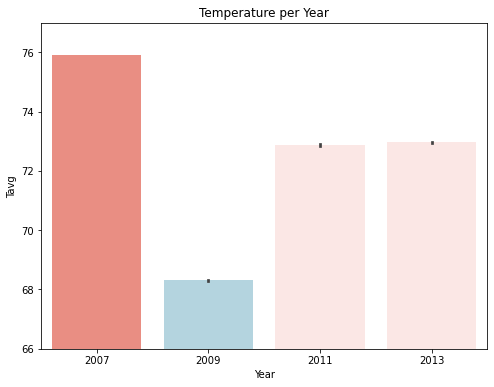

In [13]:
plt.figure(figsize=(8,6))
plt.title('Temperature per Year')
plt.ylim([66, 77])

clrs = ["salmon","lightblue","mistyrose","mistyrose"]

sns.barplot(data = train_weather, 
             x='Year', 
             y='Tavg', 
             ci = 10,
           palette=clrs);

We note that the warmest year (2007) has the highest number of WNV occurences; and the coolest year (2009) has the lowest number of WNV occurences out of the four years. This further confirmed our hypothesis that high temperature is likely to contribute to the high number of cases.

## Exploring Features (Wet Bulb & Dew Point)

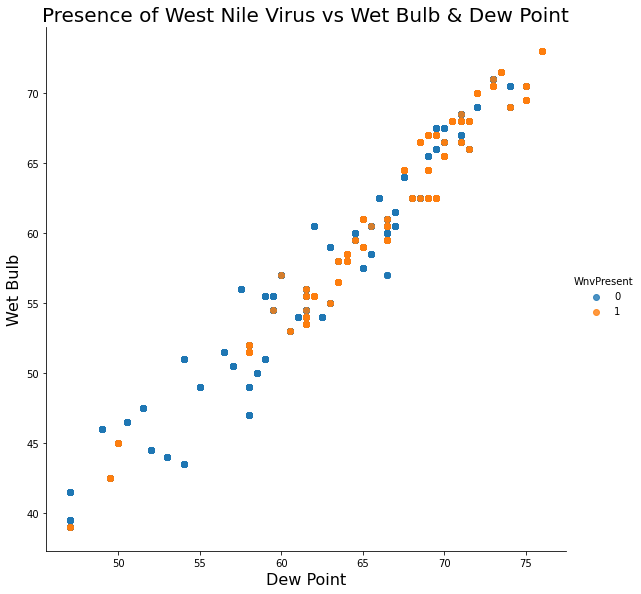

In [14]:
sns.lmplot( data=train_weather, 
           x='WetBulb', 
           y='DewPoint',  
           fit_reg=False, 
           hue='WnvPresent', 
           height=8)


plt.xlabel('Dew Point', fontsize=16)
plt.ylabel('Wet Bulb', fontsize=16)

plt.title('Presence of West Nile Virus vs Wet Bulb & Dew Point', fontsize=20);

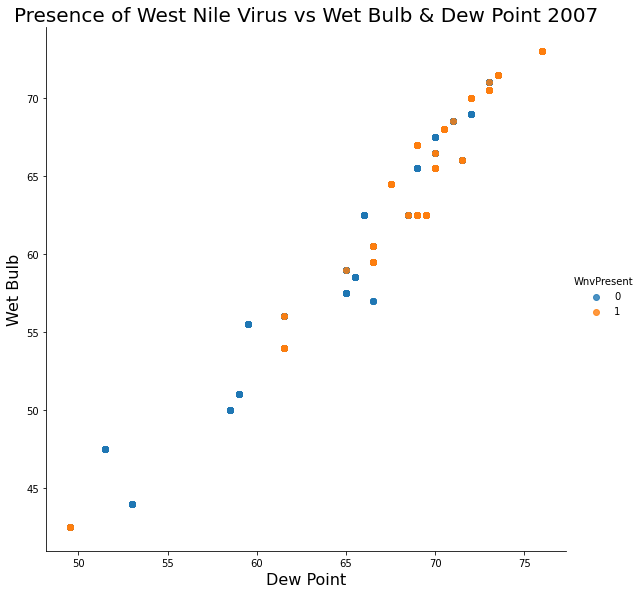

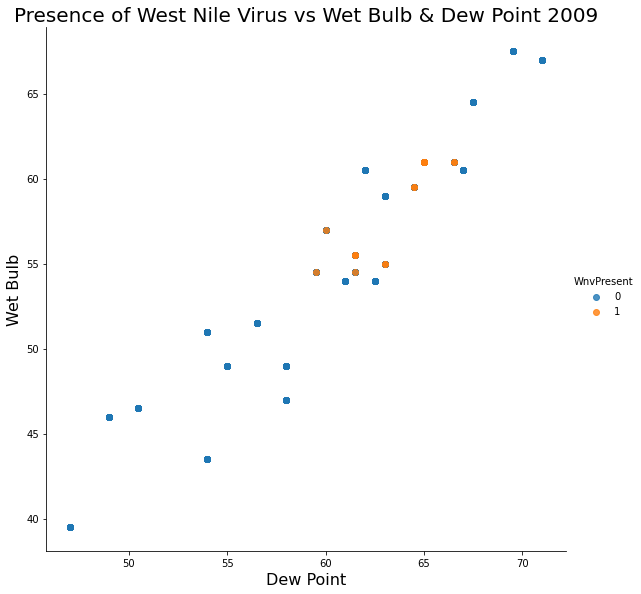

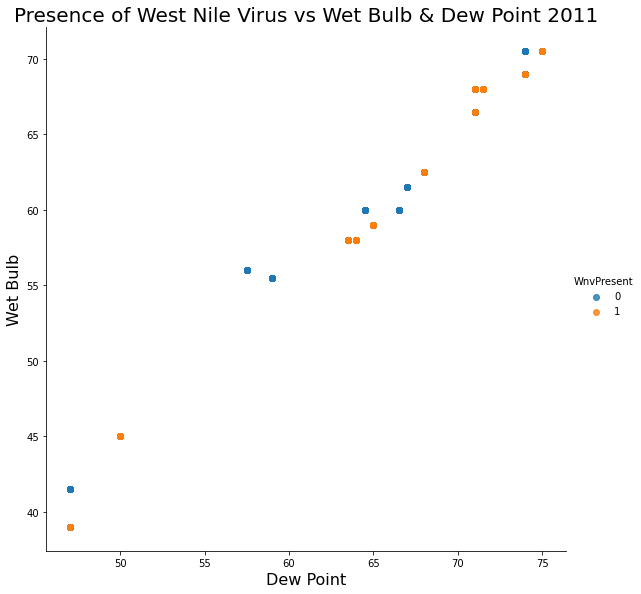

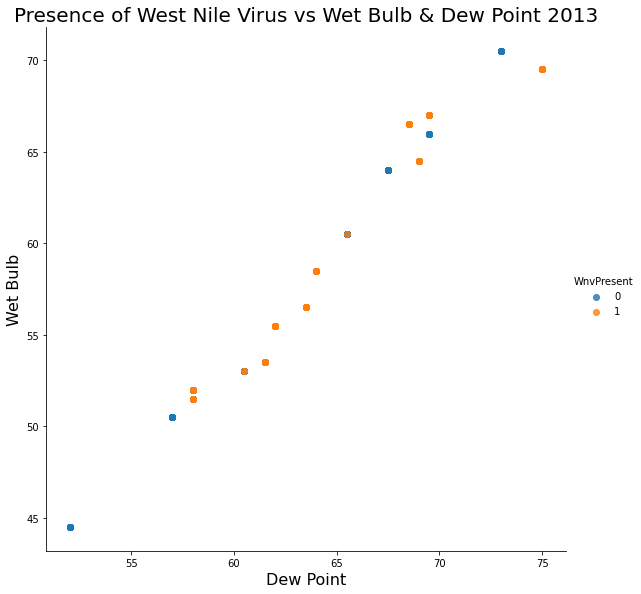

In [15]:
years = [2007, 2009, 2011, 2013]

for year in years:
    sns.lmplot( data=train_weather[train_weather['Year']==year], 
               x='WetBulb', 
               y='DewPoint',  
               fit_reg=False, 
               hue='WnvPresent', 
               height=8)
    
    
    plt.xlabel('Dew Point', fontsize=16)
    plt.ylabel('Wet Bulb', fontsize=16)

    plt.title('Presence of West Nile Virus vs Wet Bulb & Dew Point '+ str(year), fontsize=20);

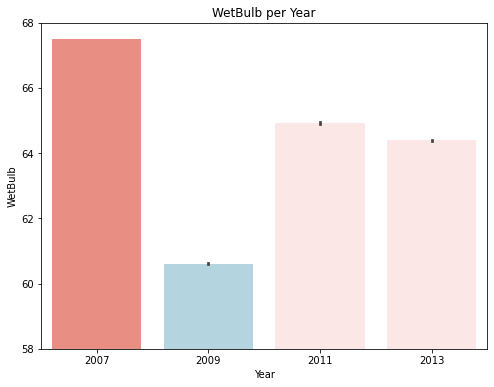

In [16]:
plt.figure(figsize=(8,6))
plt.title('WetBulb per Year')
plt.ylim([58, 68])

clrs = ["salmon","lightblue","mistyrose","mistyrose"]

sns.barplot(data = train_weather, 
             x='Year', 
             y='WetBulb', 
             ci = 10,
           palette=clrs);

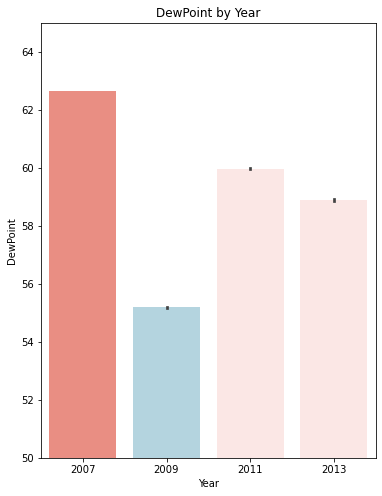

In [17]:
plt.figure(figsize=(6,8))
plt.title('DewPoint by Year')
plt.ylim([50, 65])

clrs = ["salmon","lightblue","mistyrose","mistyrose"]

sns.barplot(data = train_weather, 
             x='Year', 
             y='DewPoint', 
             ci = 10,
           palette=clrs);

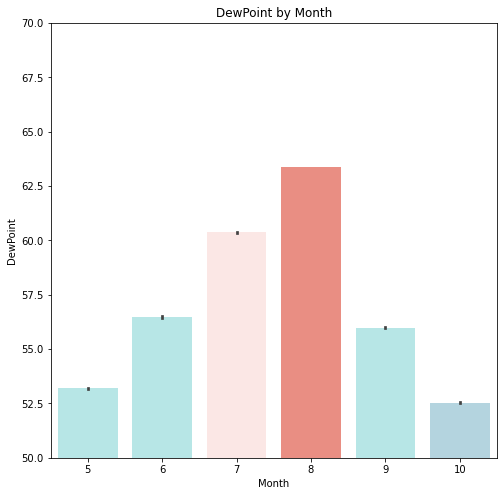

In [18]:
plt.figure(figsize=(8,8))
plt.title('DewPoint by Month')
plt.ylim([50, 70])

clrs = ["paleturquoise","paleturquoise","mistyrose", "salmon","paleturquoise",'lightblue']

sns.barplot(data = train_weather, 
             x='Month', 
             y='DewPoint', 
             ci = 10,
           palette=clrs);

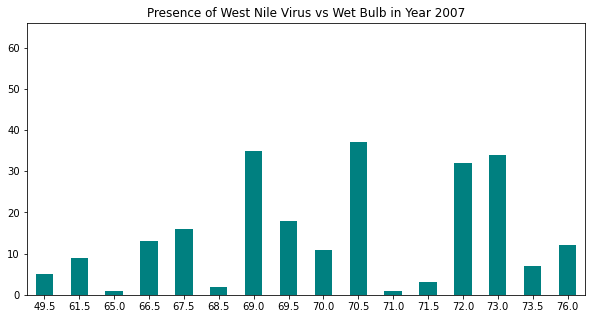

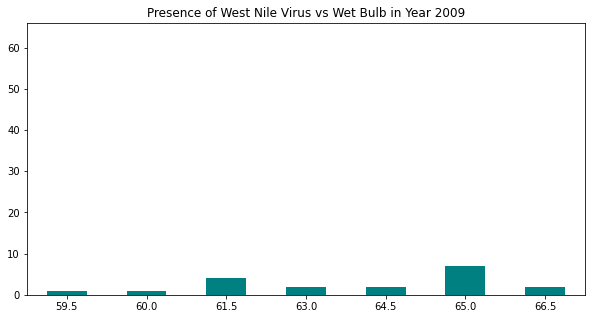

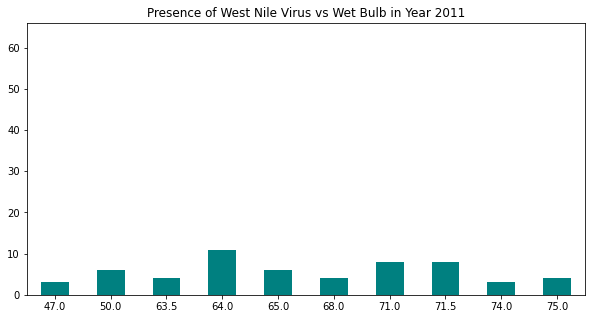

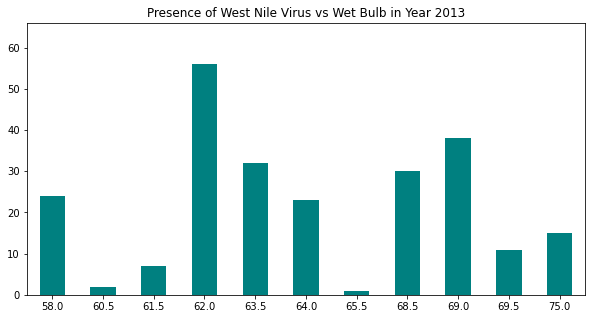

In [19]:
years = [2007, 2009, 2011, 2013]
max_val = max([train_weather[train_weather["Year"]==year].groupby(by='WetBulb')["WnvPresent"].sum().max() for year in years])


for year in years:
    plt.figure(figsize=(10,5))
    data = train_weather[(train_weather['WnvPresent']==1)
                  &(train_weather['Year']==year)]['WetBulb'].value_counts().sort_index(ascending=True)
    data.plot.bar(color="teal") 
    plt.ylim([0, max_val+10])
    plt.xticks(rotation=0)
    #plt.xlim([0, 80])
    plt.title('Presence of West Nile Virus vs Wet Bulb in Year '+ str(year))

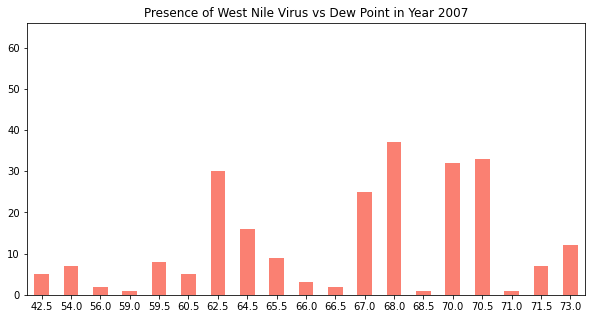

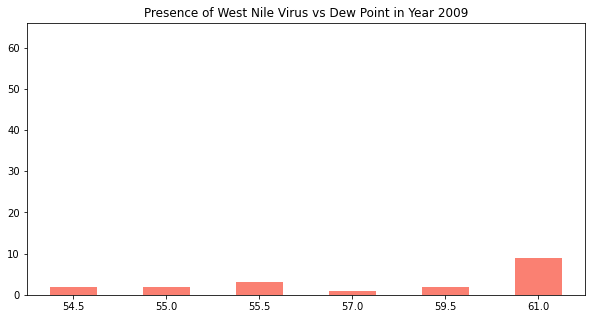

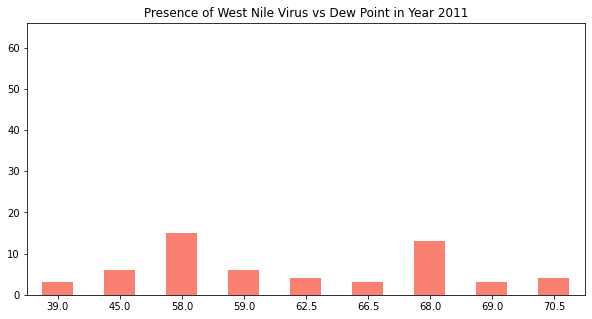

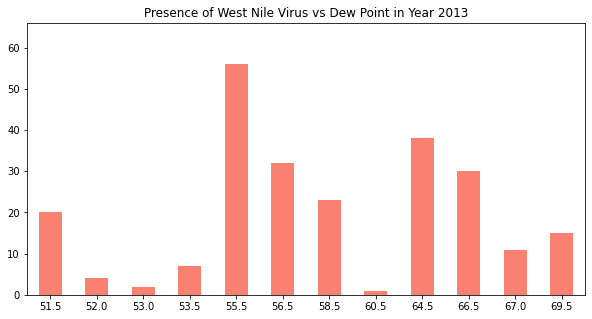

In [20]:
years = [2007, 2009, 2011, 2013]
max_val = max([train_weather[train_weather["Year"]==year].groupby(by='DewPoint')["WnvPresent"].sum().max() for year in years])

for year in years:
    plt.figure(figsize=(10,5))
    data = train_weather[(train_weather['WnvPresent']==1)
                  &(train_weather['Year']==year)]['DewPoint'].value_counts().sort_index(ascending=True)
    data.plot.bar(color="salmon") 
    plt.ylim([0, max_val+10])
    plt.xticks(rotation=0)
    #plt.xlim([0, 80])
    plt.title('Presence of West Nile Virus vs Dew Point in Year '+ str(year))

## Examining Different Mosquito Species 

In [21]:
species_all = pd.DataFrame(train_weather["Species"].value_counts())
species_all

Species
CULEX PIPIENS/RESTUANS     4752
CULEX RESTUANS             2740
CULEX PIPIENS              2699
CULEX TERRITANS             222
CULEX SALINARIUS             86
CULEX TARSALIS                6
CULEX ERRATICUS               1

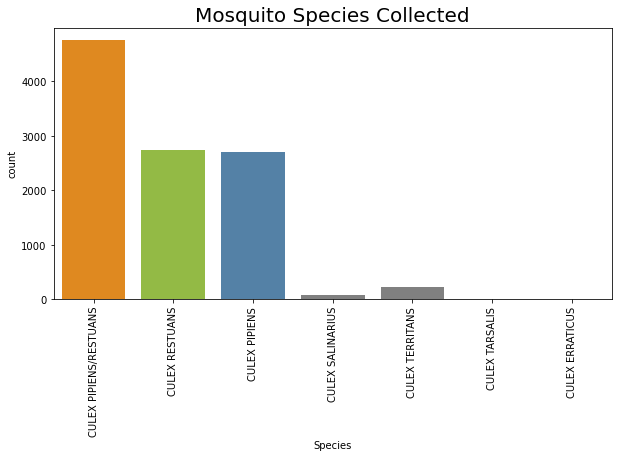

In [22]:
plt.figure(figsize=(10,5))
plt.title('Mosquito Species Collected',fontsize=20)
plt.xticks(rotation=90)

pal = ["darkorange","yellowgreen","steelblue","grey","grey","grey","grey"]
sns.countplot(train_weather["Species"], palette=pal);

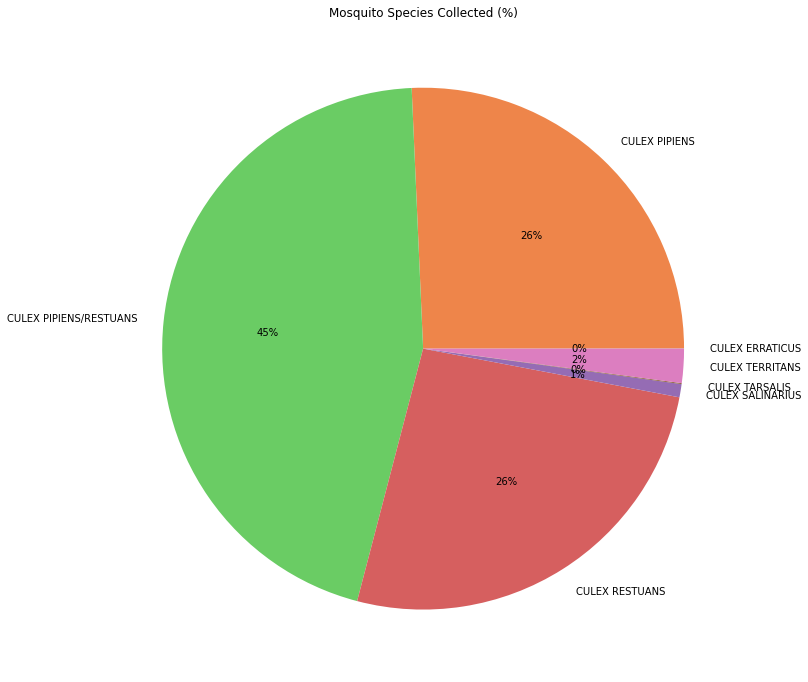

In [23]:
species = pd.DataFrame(train_weather["Species"].value_counts())
species.sort_index(inplace=True)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)

colors = sns.color_palette('muted')

ax.pie(species['Species'], 
       colors=colors, 
       labels=list(species.index), 
       labeldistance=1.1, 
       autopct='%.0f%%')

ax.set_title("Mosquito Species Collected (%)");

In [24]:
species_wnv = pd.DataFrame(train_weather[train_weather['WnvPresent']==1]["Species"].value_counts())
species_wnv

Species
CULEX PIPIENS/RESTUANS      262
CULEX PIPIENS               240
CULEX RESTUANS               49

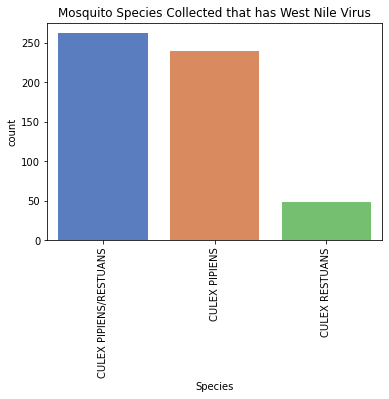

In [25]:
plt.title('Mosquito Species Collected that has West Nile Virus')
plt.xticks(rotation=90)
sns.countplot(train_weather[train_weather['WnvPresent']==1]["Species"], palette="muted");

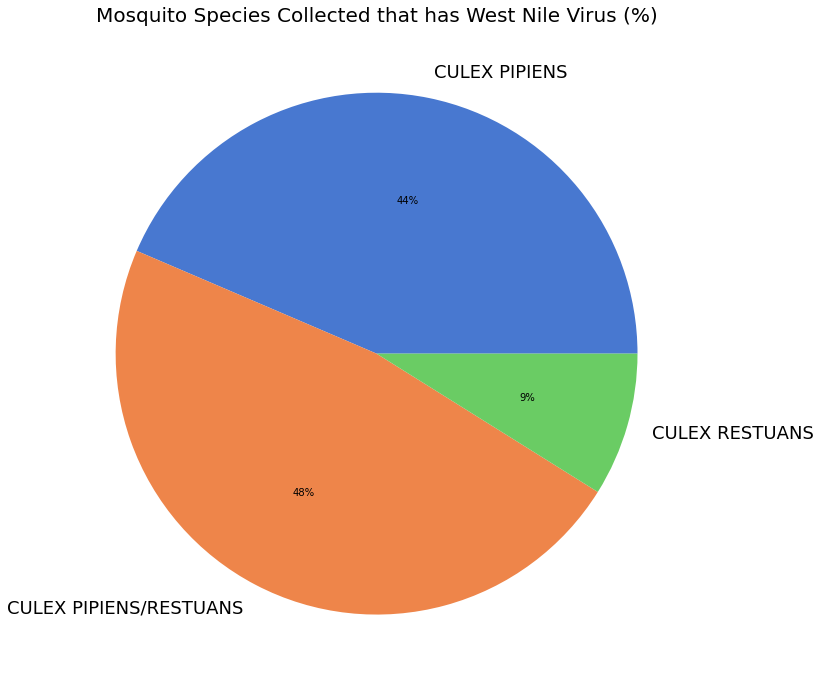

In [26]:
species = pd.DataFrame(train_weather[train_weather['WnvPresent']==1]["Species"].value_counts())
species.sort_index(inplace=True)

fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(111)

colors = sns.color_palette('muted')

patches, texts, autotexts = ax.pie(species['Species'], 
       colors=colors, 
       labels=list(species.index), 
       labeldistance=1.1, 
       autopct='%.0f%%')
texts[0].set_fontsize(18)
texts[1].set_fontsize(18)
texts[2].set_fontsize(18)
ax.set_title("Mosquito Species Collected that has West Nile Virus (%)", fontsize=20);

We note that only these 3 (out of 7) species of mosquitoes in our dataset had West Nile Virus present:
1. Culex Pipiens/Restuans
2. Culex Pipiens
3. Culex Restuans


In [27]:
species_all

Species
CULEX PIPIENS/RESTUANS     4752
CULEX RESTUANS             2740
CULEX PIPIENS              2699
CULEX TERRITANS             222
CULEX SALINARIUS             86
CULEX TARSALIS                6
CULEX ERRATICUS               1

In [28]:
species_wnv

Species
CULEX PIPIENS/RESTUANS      262
CULEX PIPIENS               240
CULEX RESTUANS               49

In [29]:
species_wnv_perc = species_wnv/species_all.loc[list(species_wnv.index)] * 100
species_wnv_perc.columns = ["Percentage of WNV"]
species_wnv_perc["Percentage of WNV"] = round(species_wnv_perc["Percentage of WNV"],2)
species_wnv_perc = species_wnv_perc.sort_values(["Percentage of WNV"], ascending=False)
species_wnv_perc

Percentage of WNV
CULEX PIPIENS                        8.89
CULEX PIPIENS/RESTUANS               5.51
CULEX RESTUANS                       1.79

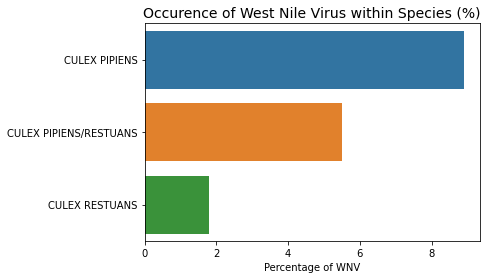

In [30]:
plt.title("Occurence of West Nile Virus within Species (%)", 
          fontsize=14);

sns.barplot(data=species_wnv_perc, 
            x='Percentage of WNV', 
            y=species_wnv_perc.index);

We also note that the species with the: 
- highest percentage of West Nile Virus present is Culex Pipiens (8.89%)
- lowest percentage of West Nile Virus present is Culex Pipiens/Restuans (1.79%)

Given this relationship, we want to place a weight that is proportional to the percentage of West Nile Virus present for each species. 

Based on the percentage of West Nile Virus present, we will round up to the nearest whole number and assign the following weights:

| Species                | Percentage of WNV | Assign Weight |
|------------------------|------------------:|---------------|
| Culex Pipiens/Restuans | 5.51              | 6             |  
| Culex Pipiens          | 8.89              | 9             |
| Culex Restuans         | 1.79              | 2             | 



In [31]:
# original species column (before weight assignnment)
train_weather['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [32]:
# new species column (after weight assignnment)
train_weather['Species'] = train_weather['Species'].map({'CULEX PIPIENS/RESTUANS': 6, 'CULEX PIPIENS': 9, 'CULEX RESTUANS': 2}).fillna(0)
train_weather['Species'].value_counts()

6.0    4752
2.0    2740
9.0    2699
0.0     315
Name: Species, dtype: int64

## Examining Locations and Spray

In [33]:
# Importing map data
map_df = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

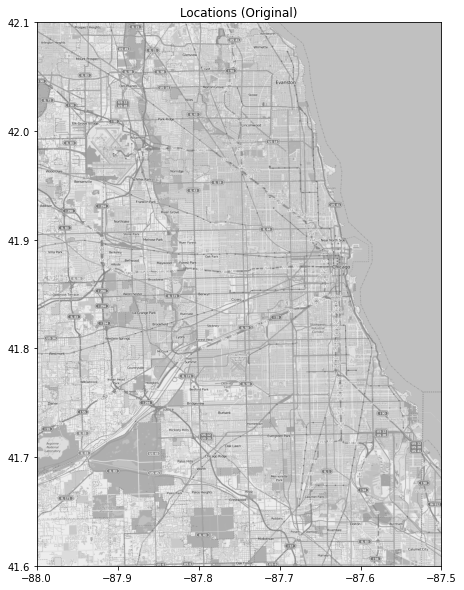

In [34]:
plt.figure(figsize=(10,10))
plt.title('Locations (Original)')
plt.imshow(map_df,
          cmap=plt.get_cmap('gray'),
          extent=(-88, -87.5, 41.6, 42.1),
          aspect=map_df.shape[0]*1.0 / map_df.shape[1]);

In [35]:
no_spray_duplicates = spray.shape[0] - spray[['Longitude', 'Latitude']].drop_duplicates().shape[0]
no_spray_out_of_range = spray[spray["Longitude"]<-88].shape[0]

print(f"Dropped {no_spray_duplicates} duplicates ")
print(f"Dropped {no_spray_out_of_range} points that are out of map range")

spray_long_lat = spray[spray["Longitude"]>-88][['Longitude', 'Latitude']].drop_duplicates().values
spray_long_lat.shape

Dropped 541 duplicates 
Dropped 95 points that are out of map range


(13615, 2)

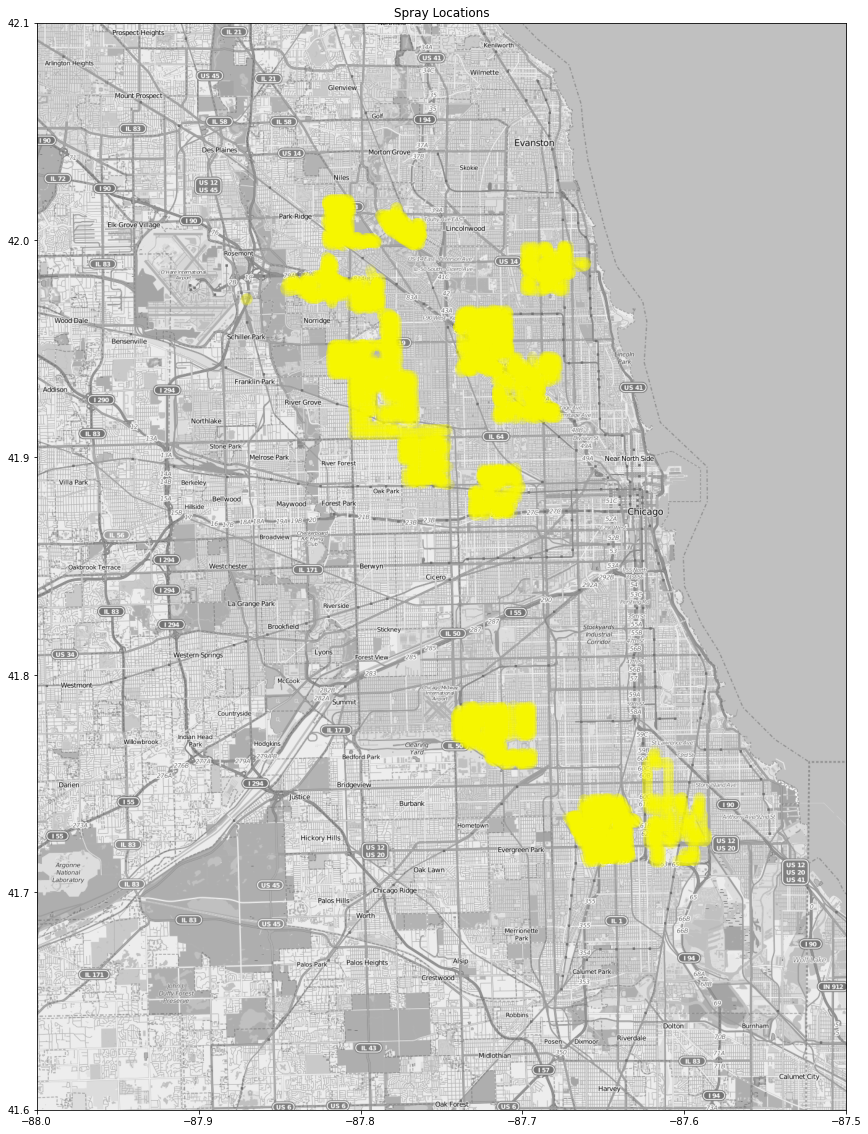

In [36]:
plt.figure(figsize=(20,20))
plt.title('Spray Locations')

plt.imshow(map_df,
          cmap=plt.get_cmap('gray'),
          extent=(-88, -87.5, 41.6, 42.1),
          aspect=map_df.shape[0]*1.0 / map_df.shape[1])

plt.scatter(spray_long_lat[:,0], spray_long_lat[:,1], s=100, c='yellow', alpha=0.1);

In [37]:
# creating a trap dataframe for plotting 
trap_df = train[['Trap','Longitude','Latitude']].drop_duplicates("Trap")
print(trap_df.shape)
trap_df.head(3)

(136, 3)


Trap  Longitude   Latitude
0  T002 -87.800991  41.954690
2  T007 -87.769279  41.994991
3  T015 -87.824812  41.974089

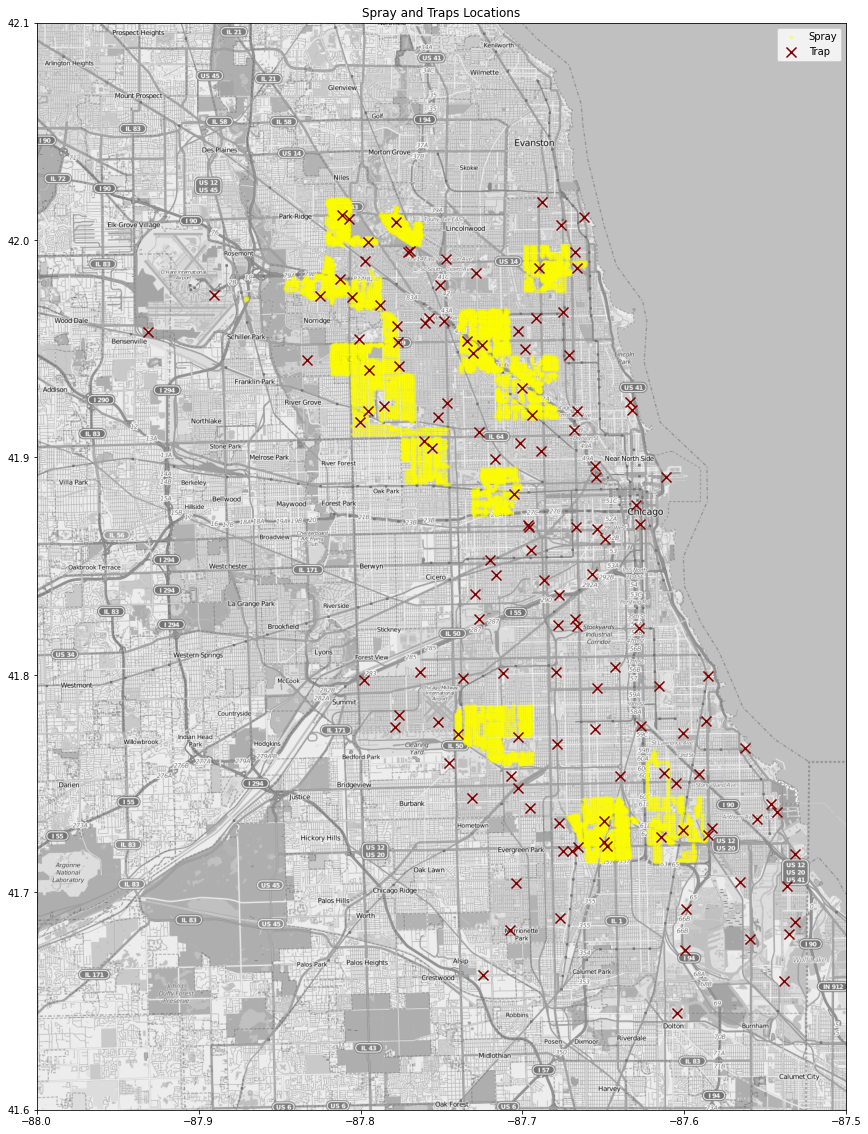

In [38]:
plt.figure(figsize=(20,20))
plt.title('Spray and Traps Locations')

plt.imshow(map_df,
          cmap=plt.get_cmap('gray'),
          extent=(-88, -87.5, 41.6, 42.1),
          aspect=map_df.shape[0]*1.0 / map_df.shape[1])

plt.scatter(spray_long_lat[:,0], 
            spray_long_lat[:,1], 
            s=10, c='yellow', alpha=0.3, label='Spray')

plt.scatter(trap_df.values[:,1], 
            trap_df.values[:,2], 
            s=100,marker='x', c='maroon', alpha=1, label='Trap')

plt.legend(loc="upper right");

In [39]:
# creating a trap and wnv present dataframe for plotting 
wnv_trap_df =  train[train["WnvPresent"]==1][['Trap','Longitude','Latitude']].drop_duplicates("Trap")

print(wnv_trap_df.shape)
wnv_trap_df.head(3)

(97, 3)


Trap  Longitude   Latitude
553  T215 -87.531635  41.686398
603  T115 -87.599862  41.673408
777  T002 -87.800991  41.954690

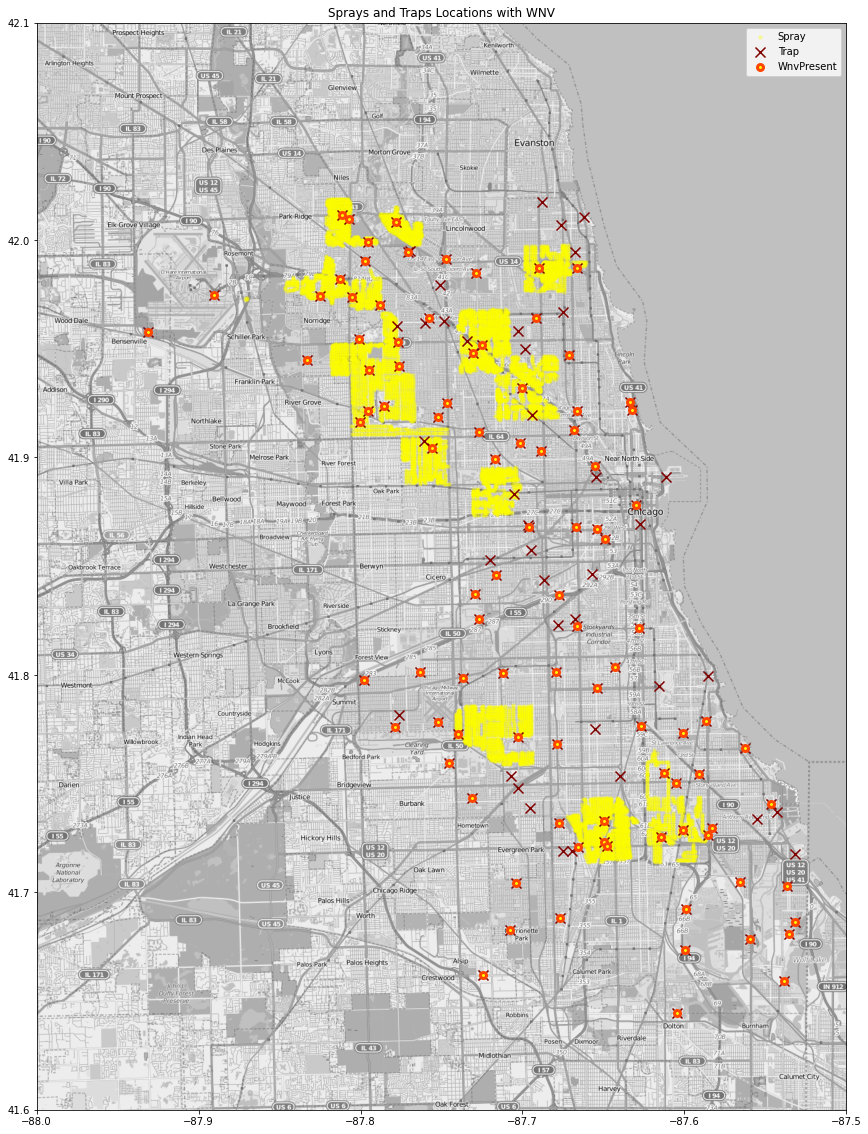

In [40]:
plt.figure(figsize=(20,20))
plt.title('Sprays and Traps Locations with WNV')

plt.imshow(map_df,
          cmap=plt.get_cmap('gray'),
          extent=(-88, -87.5, 41.6, 42.1),
          aspect=map_df.shape[0]*1.0 / map_df.shape[1])

plt.scatter(spray_long_lat[:,0], 
            spray_long_lat[:,1], 
            s=10, c='yellow', alpha=0.3, label='Spray')

plt.scatter(trap_df.values[:,1], 
            trap_df.values[:,2], 
            s=100, marker='x', c='maroon', alpha=1, label='Trap')

plt.scatter(wnv_trap_df.values[:,1], 
            wnv_trap_df.values[:,2], 
            marker='o', c='yellow',edgecolor='orangered',linewidth=3, alpha=1, label='WnvPresent')

plt.legend(loc="upper right");

From the plot, we can see that most (more than half) of the locations with WNV present were <ins>not sprayed</ins>.

# Investigating Top<font size="4">$^{\text{*}}$</font> Traps


<font size="2">**Taking 90th percentile as top*</font>

In [41]:
# Top traps with the most WNV present
top_wnv_traps = pd.DataFrame(
    train["Trap"][train["WnvPresent"] == 1].value_counts()
)

top_wnv_traps.columns = ['Wnv_count']
top_wnv_traps.head(3)

Wnv_count
T900         66
T115         41
T002         18

In [42]:
print("No. of Wnv_count at the 90th percentile:")
top_wnv_traps["Wnv_count"].quantile(0.9)

No. of Wnv_count at the 90th percentile:


10.0

In [43]:
# 90th percentile
print("Traps with the Highest no. of WNV Present (90th Percentile):")
top_wnv_traps = top_wnv_traps[:top_wnv_traps[top_wnv_traps["Wnv_count"]>=10].shape[0]]
top_wnv_traps

Traps with the Highest no. of WNV Present (90th Percentile):


Wnv_count
T900         66
T115         41
T002         18
T138         16
T003         14
T128         11
T225         11
T011         11
T903         10
T013         10
T008         10

In [44]:
print("Addresses of Traps with the Highest no. of WNV Present (90th Percentile):\n")

for trap in top_wnv_traps.index:
    print(trap+" : "+train["Address"][train["Trap"] == trap].unique()[0])

Addresses of Traps with the Highest no. of WNV Present (90th Percentile):

T900 : ORD Terminal 5, O'Hare International Airport, Chicago, IL 60666, USA
T115 : South Doty Avenue, Chicago, IL, USA
T002 : 4100 North Oak Park Avenue, Chicago, IL 60634, USA
T138 : South Stony Island Avenue, Chicago, IL, USA
T003 : 4600 Milwaukee Avenue, Chicago, IL 60630, USA
T128 : 2400 East 105th Street, Chicago, IL 60617, USA
T225 : 8200 South Kostner Avenue, Chicago, IL 60652, USA
T011 : 3600 North Pittsburgh Avenue, Chicago, IL 60634, USA
T903 : Ohare Court, Bensenville, IL 60106, USA
T013 : 6100 West Fullerton Avenue, Chicago, IL 60639, USA
T008 : 7000 North Moselle Avenue, Chicago, IL 60646, USA


In [45]:
print("Traps (with geoographic coordinates) with the highest no. of WNV Present: \n")
wnv_trap_df.set_index("Trap", drop=True, inplace=True)

top_wnv_traps = top_wnv_traps.join(wnv_trap_df, how='inner')
top_wnv_traps

Traps (with geoographic coordinates) with the highest no. of WNV Present: 



Wnv_count  Longitude   Latitude
T900         66 -87.890615  41.974689
T115         41 -87.599862  41.673408
T002         18 -87.800991  41.954690
T138         16 -87.585413  41.726465
T003         14 -87.757639  41.964242
T128         11 -87.565666  41.704572
T225         11 -87.731435  41.743402
T011         11 -87.832763  41.944869
T903         10 -87.930995  41.957799
T013         10 -87.785288  41.923738
T008         10 -87.777921  42.008314

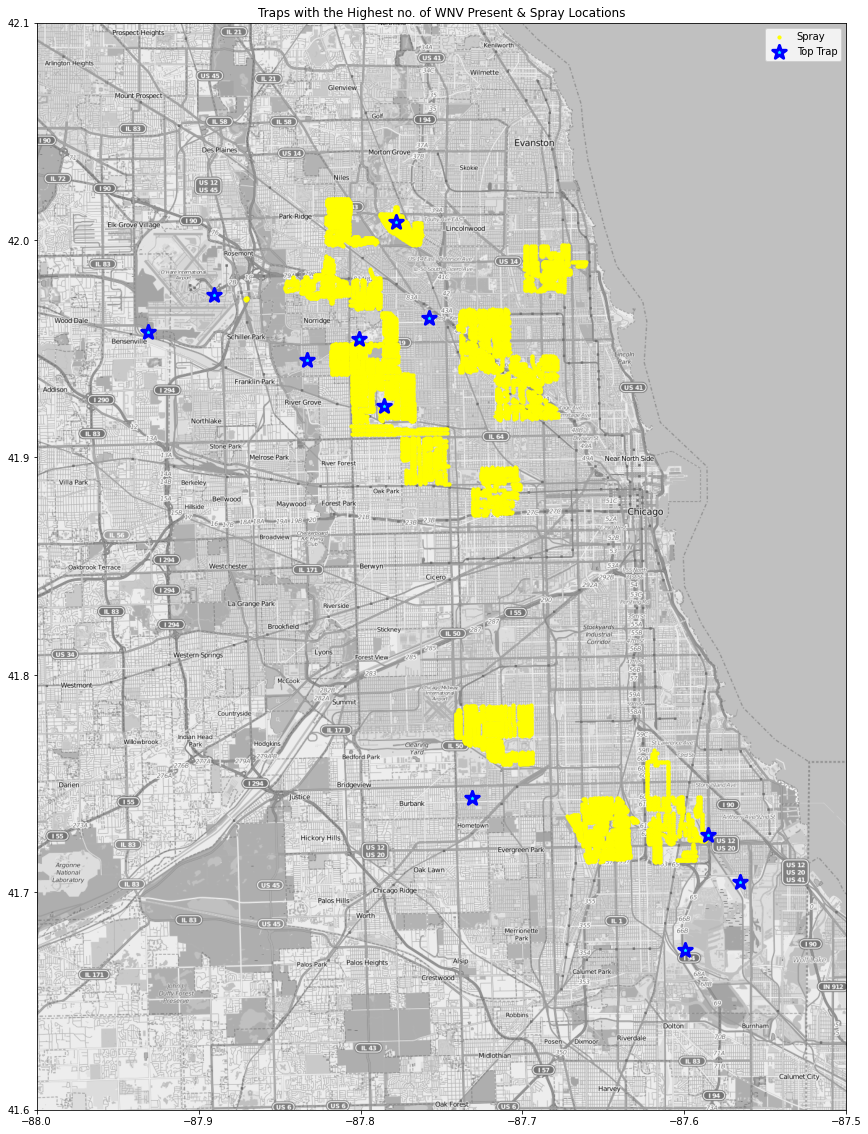

In [46]:
top_wnv_traps_long_lat = top_wnv_traps.drop("Wnv_count", axis=1).values

plt.figure(figsize=(20,20))
plt.title('Traps with the Highest no. of WNV Present & Spray Locations')

plt.imshow(map_df,
          cmap=plt.get_cmap('gray'),
          extent=(-88, -87.5, 41.6, 42.1),
          aspect=map_df.shape[0]*1.0 / map_df.shape[1])

plt.scatter(spray_long_lat[:,0], spray_long_lat[:,1], s=10, c='yellow', alpha=1, label='Spray')

plt.scatter(top_wnv_traps_long_lat[:,0], 
            top_wnv_traps_long_lat[:,1],
            edgecolor='b',linewidth=3, 
            marker='*', s=200, c='cyan', alpha=1, label='Top Trap')

plt.legend(loc="upper right");

From the plot, we can see that only 2 out of 8 of the traps with WNV present were covered by the spay locations. Which means ~75% of the top<font size="2">*</font> traps with WNV present were <ins>not sprayed</ins>.

Given that there are several traps with higher number of West Nile Virus present, we will dummify the `Trap` column, but we will keep only the top traps.

In [47]:
trap_dummy = pd.get_dummies(train_weather['Trap'], columns=['Trap'])
print(f"Dummify all Traps {trap_dummy.shape}")
trap_dummy = trap_dummy[list(top_wnv_traps.index)]
print(f"Dummify top Traps {trap_dummy.shape}")


Dummify all Traps (10506, 136)
Dummify top Traps (10506, 11)


In [48]:
train_weather = pd.concat([train_weather,trap_dummy], axis=1)
train_weather.shape

(10506, 41)

In [49]:
# dropping the remaining non-numerical columns as there are not muuch insights we can derive from these features,
train_weather.drop(['Date','Address','Street','AddressNumberAndStreet'], axis=1, inplace=True)
train_weather.shape

(10506, 37)

Preparing our `test` set:

In [50]:
print(f"Original test shape: {test.shape}")

# merging weather dataset
test_weather = pd.merge(test, weather, on=['Date', 'Year', 'Week', 'Month', 'DayOfWeek'])

# new species column (after weight assignnment)
test_weather['Species'] = test_weather['Species'].map({'CULEX PIPIENS/RESTUANS': 6, 'CULEX PIPIENS': 9, 'CULEX RESTUANS': 2}).fillna(0)

# dummifying traps
trap_dummy = pd.get_dummies(test_weather['Trap'], columns=['Trap'])
trap_dummy = trap_dummy[list(top_wnv_traps.index)]
test_weather = pd.concat([test_weather,trap_dummy], axis=1)

# dropping the remaining non-numerical columns as there are not muuch insights we can derive from these features,
test_weather.drop(['Date','Address','Street','AddressNumberAndStreet'], axis=1, inplace=True)

print(f"Final test shape: {test_weather.shape}")

Original test shape: (116293, 14)
Final test shape: (116293, 35)


In [51]:
#Export for modelling in the next notebook
train_weather.to_csv('../assets/train_final.csv', index=False)
print(train_weather.shape)
test_weather.to_csv('../assets/test_final.csv', index=False)
print(test_weather.shape)

(10506, 37)
(116293, 35)
